<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/matching_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math, tqdm, random, os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print('Seed is: ', seed)
    
SEED = 123
seed_everything(SEED)

Seed is:  123


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Load data and perform basic pre-processing

In [4]:
!curl -O https://raw.githubusercontent.com/PacktPublishing/Hands-On-One-shot-Learning-with-Python/master/Chapter02/data/data.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.2M  100 24.2M    0     0  79.3M      0 --:--:-- --:--:-- --:--:-- 79.3M


In [5]:
"""
Load data
"""

x = np.load('data.npy')
print('shape of data: ', x.shape)
x = np.expand_dims(x, axis=4)
print('shape of data after adding color channel: ', x.shape)


"""
train-val-test split
"""

np.random.shuffle(x)
x_train, x_val, x_test = x[:1200], x[1200:1411], x[1411:]

print('train 20 img samples\t: ', len(x_train))
print('val 20 img samples\t: ', len(x_val))
print('test 20 img samples\t: ', len(x_test))

shape of data:  (1623, 20, 28, 28)
shape of data after adding color channel:  (1623, 20, 28, 28, 1)
train 20 img samples	:  1200
val 20 img samples	:  211
test 20 img samples	:  212


In [6]:
"""
Pre-process data (zero center)
"""

def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

# Normalize Dataset
x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Defining dictionary of dataset (used in `get_batch()`)
datatset = {"train": x_train, "val": x_val, "test": x_test}

Set of 20 belonging to same class


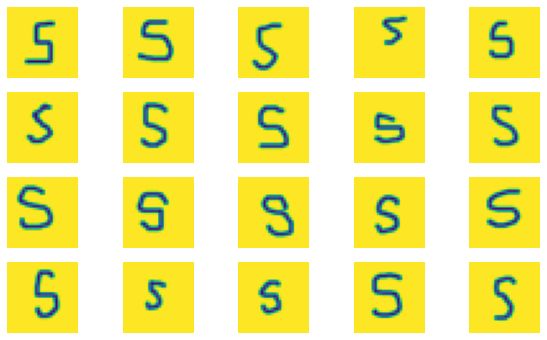

Set of 20 belonging to same class


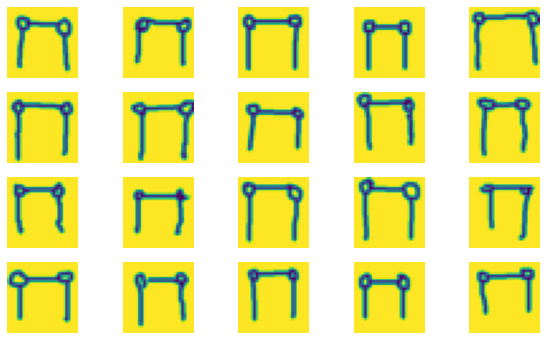

Set of 20 belonging to same class


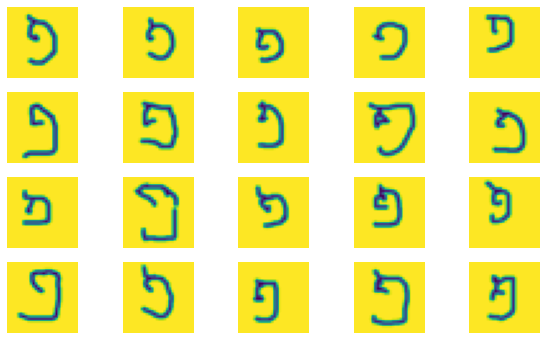

In [7]:
rows = 4
cols = 5

for set_idx in [3, 100, 35]: # idxs of sets to display
  print("="*70)
  print("Set of 20 belonging to same class")
  print("="*70)
  plt.close()

  ffig, axarr = plt.subplots(rows, cols, figsize=(10, 6))
  axarr = axarr.flatten()
  for i in range(len(axarr)):
    axarr[i].imshow(
        np.squeeze(x_train[set_idx,i,:,:,:], axis=2))
    axarr[i].axis('off')
  
  plt.show()

# Omniglot Dataset 

Designed for developing more human-like learning algorithms. Suitable for one-shot learning! Humans can recognize any alphabet by seeing just **one** sample of it. Thus, use `samples_per_class` = `1` (of avilable `20`) to train model.

- Each row (of `1623` rows) has `20` images of same classes. (See `x.shape` above)
- `samples_per_class` = `1` as we are dealing with one shot learning
- `n_classes` = `n_rows` and `classes_per_set` = `20` 

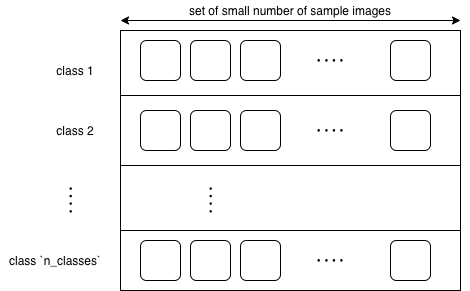

## 2. Preprocessing for novel training startegy

In matching nets, $\hat{y}_{test}$ and $\hat{y}_{train}$ are **disjoint** (but their distributions are similar. *Dogs cannot be classified if no dog-like image in  training dataset*).

So, for predicting never seen query samples $x_q$ in *target set* `target_x`, *support set's* (`support_set_x`, `support_set_y`) help is taken by computing similarities b/w items in *support set* and single $x_q$ in *target set.*

<br>

**So, should `support_set` have all possible classes to check similarity w/ `x_q` ?** It is not feasible!

**Solution:** ⁉️


<br>
<br>
<br>

Classes in support set and target set are **not disjoint!**

A *batch* in an epoch has

- **Support set:** 
- **Target set:** query point

In [8]:
def sample_batch(data):
        """
        Generates sample batch 
        :param : data - one of(train,test,val) our current dataset shape [total_classes,20,28,28,1]
        :return: [support_set_x,support_set_y,target_x,target_y] for Matching Networks
        """
        support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, data.shape[2],
                                  data.shape[3], data.shape[4]), np.float32)
        support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)
        
        target_x = np.zeros((batch_size, data.shape[2], data.shape[3], data.shape[4]), np.float32)
        target_y = np.zeros((batch_size, 1), np.int32)
        for i in range(batch_size):
            choose_classes = np.random.choice(data.shape[0], size=classes_per_set, replace=False) # choosing random classes
            choose_label = np.random.choice(classes_per_set, size=1) # label set
            choose_samples = np.random.choice(data.shape[1], size=samples_per_class + 1, replace=False)
            x_temp = data[choose_classes] # choosing classes
            x_temp = x_temp[:, choose_samples] # choosing sample batch from classes chosen outputs 20X2X28X28X1
            y_temp = np.arange(classes_per_set) # will return [0,1,2,3,...,19]
            support_set_x[i] = x_temp[:, :-1]
            support_set_y[i] = np.expand_dims(y_temp[:], axis=1) # expand dimension
            target_x[i] = x_temp[choose_label, -1]
            target_y[i] = y_temp[choose_label]
        return support_set_x, support_set_y, target_x, target_y # returns support of [batch_size, 20 classes per set, 1 sample, 28, 28,1]
    
def get_batch(dataset_name):
        """
        gen batch while training
        :param dataset_name: The name of dataset(one of "train","val","test")
        :return: a batch images
        """
        support_set_x, support_set_y, target_x, target_y = sample_batch(datatset[dataset_name])
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y

In [9]:
"""
test (support, target)
"""

batch_size=32
classes_per_set= 10 # (m) here, `20`
samples_per_class=1 # (k) here 1-shot so k=1

print("sampled batch shapes")
sx, sy, tx, ty = sample_batch(x_train)

print(sx.shape)
print(sy.shape)
print(tx.shape)
print(ty.shape)
print("Note 👆 shape of `support_set_x`, `support_set_y` is altered for training 👇")


print("\n")
print("sampled batch with `get_batch` shapes (train)")
sx, sy, tx, ty = get_batch('train')

print(sx.shape)
print(sy.shape)
print(tx.shape)
print(ty.shape)
print(sy[:3])
print(ty[:3])


print("\n")
print("sampled batch with `get_batch` shapes (val)")
sx, sy, tx, ty = get_batch('val')

print(sx.shape)
print(sy.shape)
print(tx.shape)
print(ty.shape)
print(sy[:3], ty[:3])


# see `forward` of matching network to
# know how trainig is done.

sampled batch shapes
(32, 10, 1, 28, 28, 1)
(32, 10, 1)
(32, 28, 28, 1)
(32, 1)
Note 👆 shape of `support_set_x`, `support_set_y` is altered for training 👇


sampled batch with `get_batch` shapes (train)
(32, 10, 28, 28, 1)
(32, 10)
(32, 28, 28, 1)
(32, 1)
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
[[4]
 [1]
 [5]]


sampled batch with `get_batch` shapes (val)
(32, 10, 28, 28, 1)
(32, 10)
(32, 28, 28, 1)
(32, 1)
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]] [[4]
 [6]
 [7]]


## 3. Build novel model

In [10]:
def convLayer(in_channels, out_channels, dropout_prob=0.0):
    """
    :param dataset_name: The name of dataset(one of "train","val","test")
    :return: a batch images
    """
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(dropout_prob)
    )
    return cnn_seq

class Embeddings_extractor(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, dropout_prob=0.5, image_size=28):
        super(Embeddings_extractor, self).__init__()
        """
        Build a CNN to produce embeddings
        :param layer_size:64(default)
        :param num_channels:
        :param keep_prob:
        :param image_size:
        """
        self.layer1 = convLayer(num_channels, layer_size, dropout_prob)
        self.layer2 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer3 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer4 = convLayer(layer_size, layer_size, dropout_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size

    def forward(self, image_input):
        """
        :param: Image
        :return: embeddings
        """
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        return x

In [11]:
class AttentionalClassify(nn.Module):
    def __init__(self):
        super(AttentionalClassify, self).__init__()

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarites of size[batch_size,sequence_length]
        :param support_set_y:[batch_size,sequence_length,classes_num]
        :return: Softmax pdf shape[batch_size,classes_num]
        """
        softmax = nn.Softmax(dim=1)
        softmax_similarities = softmax(similarities)
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze()
        return preds

In [12]:
class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and 
    the target image embeddings.
    """

    def __init__(self):
        super(DistanceNetwork, self).__init__()

    def forward(self, support_set, input_image):
        """
        forward pass
        :param support_set:the embeddings of the support set images.shape[sequence_length,batch_size,64]
        :param input_image: the embedding of the target image,shape[batch_size,64]
        :return:shape[batch_size,sequence_length]
        """
        eps = 1e-10
        similarities = []
        for support_image in support_set:
            sum_support = torch.sum(torch.pow(support_image, 2), 1)
            support_manitude = sum_support.clamp(eps, float("inf")).rsqrt()
            dot_product = input_image.unsqueeze(1).bmm(support_image.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_manitude
            similarities.append(cosine_similarity)
        similarities = torch.stack(similarities)
        return similarities.t()

In [13]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initial a muti-layer Bidirectional LSTM
        :param layer_size: a list of each layer'size
        :param batch_size: 
        :param vector_dim: 
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]
        self.vector_dim = vector_dim
        self.num_layer = len(layer_size)
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer, hidden_size=self.hidden_size,
                            bidirectional=True).to(device)
        
        # warning: batchsize is hardcoded!
        self.hidden = (
            torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size).to(device),
            torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size).to(device))

    def repackage_hidden(self,h):
        """Wraps hidden states in new Variables, 
        to detach them from their history."""
        if type(h) == torch.Tensor:
            return h.data
        else:
            return tuple(self.repackage_hidden(v) for v in h)
        
    def forward(self, inputs):
        self.hidden = self.repackage_hidden(self.hidden)
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output

In [14]:
test_batchsize = 128
support_size_plus_query = 20+1 # m 

test_model = BidirectionalLSTM(layer_size=[32], batch_size=test_batchsize, vector_dim=64).to(device) # 64 - out vector size

# Note: batchsize is in idx1 not in idx0
test_embeddings = torch.rand(support_size_plus_query, test_batchsize, 64).to(device)
test_model(test_embeddings).shape

# input shape same as output shape

torch.Size([21, 128, 64])

In [15]:
class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=20, \
                 num_samples_per_class=1, image_size=28):
        """
        Matching Network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings(i.e. apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        
        # Let's set all peices of Matching Networks Architecture
        self.g = Embeddings_extractor(layer_size=64, num_channels=num_channels, dropout_prob=keep_prob, image_size=image_size).to(device)
        self.f = fce # bool - if we are considering full-context embeddings
        self.c = DistanceNetwork().to(device) # cosine distance among embeddings
        self.a = AttentionalClassify().to(device) # softmax of cosine distance of embeddings
        if self.f:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize).to(device)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size,sequence_length,num_channels,image_size,image_size]
        :param support_set_y_one_hot: shape[batch_size,sequence_length,num_classes_per_set]
        :param target_image: shape[batch_size,num_channels,image_size,image_size]
        :param target_y:
        :return:

        Note: all are vector operations on batch!
        """
        # print(support_set_images.shape)
        # print(support_set_y_one_hot.shape)
        # print(target_image.shape)
        # print(target_y.shape)

        # produce embeddings for support set images
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):
            gen_encode = self.g(support_set_images[:, i, :, :])
            encoded_images.append(gen_encode)
            
        # produce embeddings for target images
        gen_encode = self.g(target_image)
        encoded_images.append(gen_encode)

        # To tensors. Note: batch trick used in encoded_images by converting
        # shape: (support_size-m, batch_size, embbedding ...)
        output = torch.stack(encoded_images,dim=0)
        # print('stacked embeddings shape', output.shape) #[21, 128, 64]

        
        # if we are considering full-context embeddings
        if self.f:
            output = self.lstm(output)
            
        # get similarities between support set embeddings and target
        # [In batch]
        # total `support-size-m` similarities for `m` images against query image 
        similarites = self.c(support_set=output[:-1], input_image=output[-1])

        # Note: (support_size-m, batch_size, ..) >> (batch_size, support_size-m)
        # print('sim shape: ', similarites.shape) 
        
        # produce predictions for target probabilities
        preds = self.a(similarites, support_set_y=support_set_y_one_hot)

        # shape same dims as similarities (batchsize, support-size)
        # print('pred shape: ', preds.shape) 

        # calculate the accuracy
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return [values, indices], accuracy, crossentropy_loss

In [16]:
def run_epoch(total_train_batches, name='train'):
    """
    Run the training epoch
    :param total_train_batches: Number of batches to train on
    :return:
    """
    total_c_loss = 0.0
    total_accuracy = 0.0
    for i in range(int(total_train_batches)):
            x_support_set, y_support_set, x_target, y_target = get_batch(name)
            x_support_set = torch.from_numpy(x_support_set).float().to(device)
            y_support_set = torch.from_numpy(y_support_set).long().to(device)
            x_target = torch.from_numpy(x_target).float().to(device)
            y_target = torch.from_numpy(y_target).squeeze().long().to(device)

            # convert to one hot encoding
            y_support_set = y_support_set.unsqueeze(2).to(device)
            sequence_length = y_support_set.size()[1]
            batch_size = y_support_set.size()[0]
            y_support_set_one_hot = torch.zeros(batch_size, sequence_length, classes_per_set).to(device)
            y_support_set_one_hot = y_support_set_one_hot.scatter_(2,y_support_set.data,1)

            # reshape channels and change order
            size = x_support_set.size()
            x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
            x_target = x_target.permute(0, 3, 1, 2)
            _, acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

            # optimize process
            optimizer.zero_grad()
            c_loss.backward()
            optimizer.step()

            iter_out = "tr_loss: {}, tr_accuracy: {}".format(c_loss, acc)
            total_c_loss += c_loss
            total_accuracy += acc

    total_c_loss = total_c_loss / total_train_batches
    total_accuracy = total_accuracy / total_train_batches
    return total_c_loss, total_accuracy

In [17]:
batch_size= 128 # (bigger batch size, smoother the training)
num_channels=1
lr=1e-3
image_size=28
classes_per_set=20 # try this!
samples_per_class=1
keep_prob=0.0
fce=True
wd=0.001 # 0
matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, lr, fce, classes_per_set,
                                samples_per_class, image_size).to(device)
total_iter = 0
total_train_iter = 0
optimizer = torch.optim.Adam(matchNet.parameters(), lr=lr, weight_decay=wd)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True) 

# Training setup
total_epochs = 100
total_train_batches = 10
total_val_batches = 5
total_test_batches = 5

In [18]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
test_loss,test_accuracy=[],[]

for e in range(total_epochs):
    ############################### Training Step ##########################################
    total_c_loss, total_accuracy = run_epoch(total_train_batches,'train')
    train_loss.append(total_c_loss)
    train_accuracy.append(total_accuracy)
    
    ################################# Validation Step #######################################
    total_val_c_loss, total_val_accuracy = run_epoch(total_val_batches, 'val')
    scheduler.step(total_val_c_loss)
    val_loss.append(total_val_c_loss)
    val_accuracy.append(total_val_accuracy)
    print("Epoch {}: train_loss:{:.2f} train_accuracy:{:.2f} valid_loss:{:.2f} valid_accuracy:{:.2f}".
          format(e, total_c_loss, total_accuracy, total_val_c_loss, total_val_accuracy))

Epoch 0: train_loss:2.97 train_accuracy:0.21 valid_loss:2.94 valid_accuracy:0.34
Epoch 1: train_loss:2.90 train_accuracy:0.43 valid_loss:2.86 valid_accuracy:0.54
Epoch 2: train_loss:2.83 train_accuracy:0.56 valid_loss:2.79 valid_accuracy:0.59
Epoch 3: train_loss:2.76 train_accuracy:0.65 valid_loss:2.72 valid_accuracy:0.68
Epoch 4: train_loss:2.72 train_accuracy:0.69 valid_loss:2.69 valid_accuracy:0.71
Epoch 5: train_loss:2.69 train_accuracy:0.72 valid_loss:2.66 valid_accuracy:0.74
Epoch 6: train_loss:2.65 train_accuracy:0.75 valid_loss:2.62 valid_accuracy:0.80
Epoch 7: train_loss:2.63 train_accuracy:0.78 valid_loss:2.62 valid_accuracy:0.80
Epoch 8: train_loss:2.62 train_accuracy:0.78 valid_loss:2.60 valid_accuracy:0.82
Epoch 9: train_loss:2.60 train_accuracy:0.81 valid_loss:2.58 valid_accuracy:0.83
Epoch 10: train_loss:2.58 train_accuracy:0.83 valid_loss:2.57 valid_accuracy:0.84
Epoch 11: train_loss:2.59 train_accuracy:0.80 valid_loss:2.55 valid_accuracy:0.87
Epoch 12: train_loss:2.57 

KeyboardInterrupt: ignored

In [19]:
total_test_c_loss, total_test_accuracy = run_epoch(total_test_batches,'test')
print("test_accuracy:{}%".format(total_test_accuracy*100))

test_accuracy:84.0625%


In [20]:
def plot_loss(train,val,name1="train_loss",name2="val_loss",title=""):
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

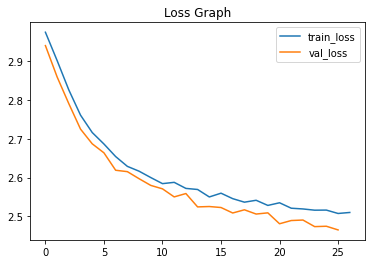

In [21]:
plot_loss(train_loss,val_loss,"train_loss", "val_loss", "Loss Graph")

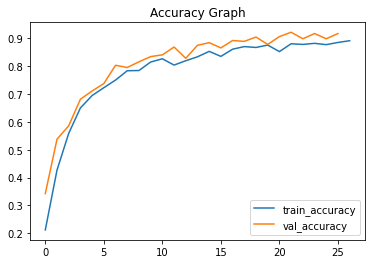

In [22]:
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy","Accuracy Graph")

<br>

(128, 20, 28, 28, 1)
(128, 20)
(128, 28, 28, 1)
(128, 1)
Set of 20 belonging to same class


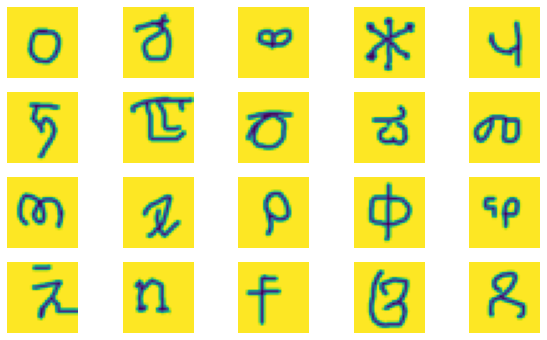

Set of 20 belonging to same class


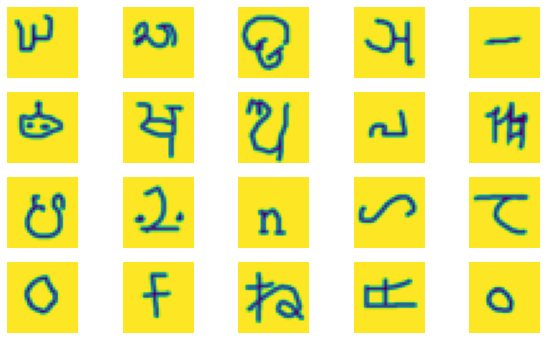

Set of 20 belonging to same class


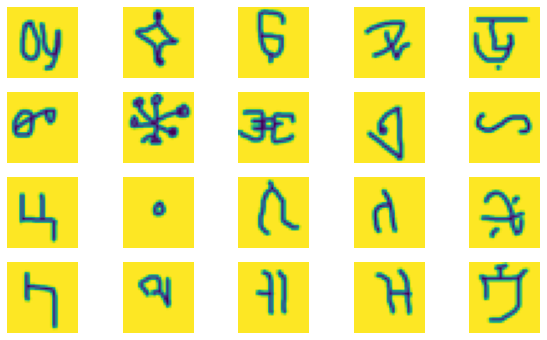

In [24]:
x_support_set, y_support_set, x_target, y_target = get_batch('test')

# plot 
print(x_support_set.shape)
print(y_support_set.shape)
print(x_target.shape)
print(y_target.shape)


# todo: plot pred class, confidence and target image 
for set_idx in [3, 100, 35]: # idxs of sets to display
  print("="*70)
  print("Set of 20 belonging to same class")
  print("="*70)
  plt.close()
  ffig, axarr = plt.subplots(rows, cols, figsize=(10, 6))
  axarr = axarr.flatten()
  for i in range(len(axarr)):
    axarr[i].imshow(
        np.squeeze(x_support_set[set_idx,i,:,:,:], axis=2))
    axarr[i].axis('off')
  plt.show()

x_support_set = torch.from_numpy(x_support_set).float().to(device)
y_support_set = torch.from_numpy(y_support_set).long().to(device)
x_target = torch.from_numpy(x_target).float().to(device)
y_target = torch.from_numpy(y_target).squeeze().long().to(device)

# convert to one hot encoding
y_support_set = y_support_set.unsqueeze(2).to(device)
sequence_length = y_support_set.size()[1]
batch_size = y_support_set.size()[0]
y_support_set_one_hot = torch.zeros(batch_size, sequence_length, classes_per_set).to(device)
y_support_set_one_hot = y_support_set_one_hot.scatter_(2,y_support_set.data,1)

# reshape channels and change order
size = x_support_set.size()
x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
x_target = x_target.permute(0, 3, 1, 2)
_, acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)